In [1]:
import numpy as np
# 
#     This is a 2-D precipitation solution for the linear model. 
#     Code by Ethan Gutmann, based on Smith and Barstad.
# 
def linear_orographic_precipitation(topo, U, dx):
    cw  = 1.1 # 1.1       # efficiency factor related to environmental lapse rate
    cwqv= cw * 0.01       # cw * mixing ratio at mountain base
    z0  = 0      # 0      # meters
    tauf= 1500   # 1500   # seconds Fall speed time constant
    tauc= 500    # 500    # seconds cloud to rain conversion rate time constant
    hw  = 3000   # 3000   # m water vapor scale height
    Ndsq= 0.0011 # 0.0011 # 1/s^2 Brunt-Vaisalla frequency squared
    Fzs = np.fft.fftshift(np.fft.fft(topo))
    
    Nx = Fzs.shape[0]
    m = np.ones(Nx)
    FSterm = np.zeros(Nx).astype('complex')
    # FSraw = np.zeros(Nx).astype('complex')
    FPterm = np.zeros(Nx).astype('complex')
    i = np.sqrt(np.complex64(-1))

    # related to wave numbers
    k    = np.linspace(-np.pi/dx,np.pi/dx,Nx)
    sig  = U*k
    denom = sig**2 # -cori**2 # don't bother with coriollis force in 2D case
    # warning: nonhydrostatic version better for smaller-scale mountains(?). 
    msq = (Ndsq/denom * (k**2)).astype('complex64')                     # vertical wave number, hydrostatic
    m = np.sign(sig)*np.abs(np.sqrt(Ndsq)/U)                            # vertical wave number, hydrostatic (eqn 14 in SB'04 (?))

    # FSraw  = i*cwqv*Fzs*sig*np.exp(-z0/hw)                            # the raw upslope (~Smith'79)
    FSterm = (i*cwqv*Fzs*sig/(1-i*m*hw))                                # simple, hydrostatic solution (eqn 16 in SB'04)
    FPterm = FSterm/((1+i*sig*tauc)*(1+i*sig*tauf))                     # this also includes time delays and dynamics (eqn 5 in SB'04)

    #  bring all back from Fourier space:
    # S      = Nx*np.fft.ifft(np.fft.ifftshift(FSterm))
    # Sraw   = Nx*np.fft.ifft(np.fft.ifftshift(FSraw))
    Pt     = np.real(Nx*np.fft.ifft(np.fft.ifftshift(FPterm)))

    #  trucate negative values as unphysical these are areas with greater evaporative potential than available precipitation
    Pt[Pt<0]=0
    return Pt
    

Text(0.5, 1.0, 'Ideal topography')

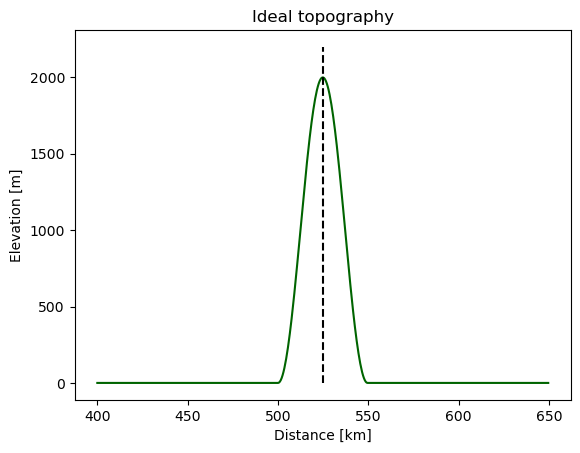

In [2]:
import matplotlib.pyplot as plt

buffer = 1000
show = 200
topo = np.concatenate([np.zeros(buffer), 1 + np.sin(np.arange(100)/99.0 * 2*np.pi - np.pi/2), np.zeros(buffer)]) * 1000
nx = topo.shape[0]
dx = 500
x = np.arange(nx)*dx
center = nx/2 * dx/1000

plt.plot(x[buffer-show:-buffer+show]/1000, topo[buffer-show:-buffer+show], color="darkgreen")
plt.plot([center, center], [0,np.max(topo)*1.1], color="black", linestyle="--")
plt.xlabel("Distance [km]")
plt.ylabel("Elevation [m]")
plt.title("Ideal topography")

Text(0.5, 1.0, 'Linear Orographic Model')

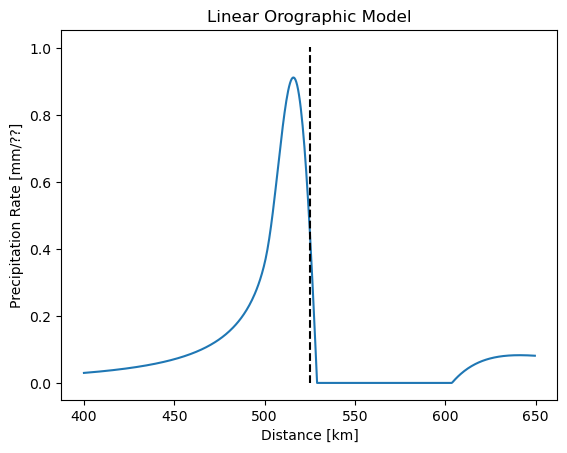

In [3]:
pcp = linear_orographic_precipitation(topo, 10, 200)

plt.plot(x[buffer-show:-buffer+show]/1000, pcp[buffer-show:-buffer+show])
plt.plot([center, center], [0,np.max(pcp)*1.1], color="black", linestyle="--")
plt.xlabel("Distance [km]")
plt.ylabel("Precipitation Rate [mm/??]")
plt.title("Linear Orographic Model")